In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common.layers import TwoLayerNet, ConvNet
from sklearn.model_selection import train_test_split
import pickle
import Augmentor
import cv2
import PIL
import h5py
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.utils import array_to_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12390195220909164725
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7798259712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4070131317412776553
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# HDF5 イテレータ実装

In [2]:
class dataIter(object):
    def __init__(self, batch_size=1, dtype='train', path='input_data.hdf5', use_auged_data=False):
        if use_auged_data:
            path='data/auged_input_data.hdf5'
        else:
            path='data/input_data.hdf5'
        self.current = 0
        self.dtype=dtype
        self.path=path
        self.batch_size=batch_size
        self.size = self.hdf_len(self.dtype, path)
        self.idx = np.arange(self.size)
        np.random.shuffle(self.idx)
        
        if self.dtype=='train':
            self.iter_num = np.ceil(self.size / self.batch_size).astype(np.int32)
        else:
            self.iter_num =1

    def __iter__(self):
        return self

    def __next__(self):
        if self.current == self.iter_num:
            raise StopIteration()
        
        if self.dtype=='train':
            mask = np.sort(self.idx[self.batch_size*self.current :self.batch_size*(self.current+1)])
            X_train, y_train=self.load_hdf(self.dtype, self.path, mask)
        else:
            X_train, y_train=self.load_hdf(self.dtype, self.path)

        self.current += 1
        return X_train, y_train
    
    def hdf_len(self, dtype, path):
        with h5py.File(path, 'r') as f:
            len=f[f'X_{dtype}'].shape[0]
        return len

    def load_hdf(self, dtype, path, mask=None):
        with h5py.File(path, 'r') as f:
            if dtype=='train':
                X=f[f'X_{dtype}'][mask]
                y=f[f'y_{dtype}'][mask]
            else:
                X=f[f'X_{dtype}'][:]
                y=f[f'y_{dtype}'][:]
            scaled_X=self.MinMaxScaler(X)
            scaled_y=self.MinMaxScaler(y)
        return scaled_X, scaled_y
            
    def MinMaxScaler(self, data):
        scaled_data= (data - data.min()) / (data.max()- data.min())
        scaled_data=scaled_data.astype('float32')
        return scaled_data
        

# 最適化アルゴリズム

In [3]:
class SGD:
    """
    Stochastic Gradient Descent
    """
    def __init__(self, lr=0.01):
        """
        lr : 学習係数 learning rate
        """
        self.lr = lr
        
    def update(self, params, grads):
        """
        重みの更新
        """
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class NesterovAG:
    """
    Nesterov Accelerated Gradient
    """
    def __init__(self, lr=0.01, momentum=0.9):
        """
        lr : 学習係数 learning rate
        momentm : モーメンタム係数
        """
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.v is None:
            """
            初回のみ
            """
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        # 重みを更新
        for key in params.keys():
            v_pre = self.v[key].copy()
            self.v[key] = v_pre * self.momentum - self.lr * grads[key]
            params[key] += -self.momentum* v_pre + (self.momentum+1) * self.v[key]


class RMSProp:
    """
    RMSProp
    """
    def __init__(self, lr=0.01, rho=0.9):
        """
        lr : 学習係数 learning rate
        rho : 減衰率
        """
        self.lr = lr
        self.h = None
        self.rho = rho
        self.epsilon = 1e-6
        
    def update(self, params, grads):
        """
        重みの更新
        """
        if self.h is None:
            """
            初回のみ
            """
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.rho * self.h[key] + (1 - self.rho) * grads[key] * grads[key]          
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + self.epsilon) ) # 原論文に合わせてepsilonをルートの中に入れる

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## 学習

In [ ]:
epochs = 50
batch_size =4096
lr = 0.01
optimizer_param={'lr':0.001}
use_auged_data=True
use_batchnorm=True

# 2層NNのオブジェクト生成
# tnet = TwoLayerNet(input_size=28*28, hidden_size=10, output_size=15)

# CNNのオブジェクト生成
tnet = ConvNet(input_dim=(1, 28, 28), output_size=10, use_batchnorm=use_batchnorm)
optimizer=Adam(**optimizer_param)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
test=dataIter(dtype='test')
X_test, y_test=next(test)
min_loss=10
for epoch in range(epochs):
    print("epoch=%s"%epoch)
    trainer=dataIter(batch_size = batch_size, dtype='train', use_auged_data=use_auged_data)
    if epoch==0:
        print(trainer.size)
    for X_train, y_train in trainer:
        # ミニバッチの生成
        x_ = X_train
        y_ = y_train
        
        # 勾配の計算
        grads = tnet.gradient(x_, y_)
        
        # パラメータの更新
        optimizer.update(tnet.params, grads)
#         for key in tnet.params.keys():
#     #         print(key)
#             tnet.params[key] -= lr * grads[key]

    ## 学習経過の記録
    
    # テストデータにおけるloss
    loss=tnet.loss(X_test, y_test)
    test_loss.append(loss)

    # テストデータにて精度を算出
    acc=tnet.accuracy(X_test, y_test)
    test_accuracy.append(acc)
    
    if loss<min_loss:
        min_loss=loss
        with open("model.pickle", "wb") as f:
            pickle_param=tnet.params.copy()
            pickle_param['use_batchnorm']=use_batchnorm
            pickle_param['layer_type']=tnet.param_layers
            if use_batchnorm:
                for i in range(len(tnet.param_layers)-1):
                    pickle_param['moving_mean'+str(i+1)]=tnet.layers['BatchNorm'+str(i+1)].moving_mean
                    pickle_param['moving_var'+str(i+1)]=tnet.layers['BatchNorm'+str(i+1)].moving_var
            pickle.dump(pickle_param, f)
    
    print(f"loss:{loss}, acc:{acc}")
    print("===================================")

In [5]:
tnet.layers['BatchNorm1'].moving_mean, tnet.layers['BatchNorm1'].moving_var

(array([-1.53166568e-02, -1.84455398e-02,  5.45859649e-02,  1.19861559e-02,
         3.40454817e-03,  2.31033178e-02, -8.62257266e-03, -2.93362126e-02,
         5.01830298e-02, -6.93502795e-06,  7.79893803e-05,  1.24700389e-03,
        -3.04627624e-02,  8.91241172e-03,  3.34881834e-02, -1.46399552e-02]),
 array([0.00063657, 0.00078861, 0.00352264, 0.0006942 , 0.00044335,
        0.00080195, 0.00037079, 0.00114221, 0.00307606, 0.00069433,
        0.00104417, 0.00074036, 0.0012736 , 0.001105  , 0.00156506,
        0.00055882]))

In [6]:
pickle_param

{'W1': array([[[[ 0.01155928, -0.06407042,  0.01643367],
          [ 0.02740267, -0.04837341, -0.04678654],
          [ 0.0247842 ,  0.05596439, -0.03170075]]],
 
 
        [[[ 0.01162039, -0.03829449,  0.07428935],
          [ 0.03961147,  0.0179576 , -0.0668017 ],
          [ 0.00511406, -0.07251105, -0.03051983]]],
 
 
        [[[ 0.04176826, -0.00060725,  0.02760783],
          [-0.00112271,  0.02712433,  0.01181659],
          [ 0.04712185,  0.02109746,  0.01633243]]],
 
 
        [[[ 0.00985614, -0.00569544, -0.05306335],
          [-0.04468789, -0.00317613, -0.00425702],
          [ 0.09803632,  0.047356  , -0.00213981]]],
 
 
        [[[ 0.1191144 , -0.06640767,  0.03183419],
          [-0.00654747, -0.11187425,  0.04394652],
          [-0.02851425, -0.00310328,  0.03500543]]],
 
 
        [[[-0.0060086 ,  0.06269103, -0.06458933],
          [-0.00419812,  0.03387211,  0.04397006],
          [-0.01607756, -0.00105644,  0.03244221]]],
 
 
        [[[ 0.06216076, -0.09491286, -0.

In [7]:
pickle_param['layer_type']

['Conv1', 'Conv2', 'Conv3', 'Conv4', 'Conv5', 'Conv6', 'Affine1', 'Affine2']

In [8]:
pickle_param['gamma1']

array([1.02995264, 1.05554894, 0.97587016, 0.97940318, 1.00011536,
       0.95382072, 1.04584706, 1.01689464, 0.92904825, 1.003312  ,
       1.03586559, 1.13876533, 1.03038169, 0.97717672, 0.94869013,
       1.02090061])

In [9]:
tnet.layers

OrderedDict([('Conv1', <common.layers.Convolution at 0x133e31dca30>),
             ('BatchNorm1',
              <common.layers.BatchNormalization at 0x133e31dc850>),
             ('ReLU1', <common.layers.ReLU at 0x133e31dc9a0>),
             ('Conv2', <common.layers.Convolution at 0x133e31dc910>),
             ('BatchNorm2',
              <common.layers.BatchNormalization at 0x133e31dc4c0>),
             ('ReLU2', <common.layers.ReLU at 0x133e31dc430>),
             ('Pool1', <common.layers.MaxPooling at 0x133e31dc460>),
             ('Conv3', <common.layers.Convolution at 0x133e31dc340>),
             ('BatchNorm3',
              <common.layers.BatchNormalization at 0x133e31dc400>),
             ('ReLU3', <common.layers.ReLU at 0x133e31dc3a0>),
             ('Conv4', <common.layers.Convolution at 0x133e31dc6d0>),
             ('BatchNorm4',
              <common.layers.BatchNormalization at 0x133e31dc7f0>),
             ('ReLU4', <common.layers.ReLU at 0x133e31dc760>),
             ('

In [10]:
len(pickle_param['layer_type'])

8

In [11]:
tnet.layers.keys()

odict_keys(['Conv1', 'BatchNorm1', 'ReLU1', 'Conv2', 'BatchNorm2', 'ReLU2', 'Pool1', 'Conv3', 'BatchNorm3', 'ReLU3', 'Conv4', 'BatchNorm4', 'ReLU4', 'Pool2', 'Conv5', 'BatchNorm5', 'ReLU5', 'Conv6', 'BatchNorm6', 'ReLU6', 'Pool3', 'Affine1', 'BatchNorm7', 'ReLU7', 'Drop1', 'Affine2', 'Drop2'])

In [12]:
tnet.layers["BatchNorm1"].beta

array([-0.08296873, -0.04521057,  0.04046325,  0.00613922,  0.0863783 ,
        0.00946237,  0.02410412, -0.03435116, -0.06079766,  0.0063521 ,
       -0.0188009 ,  0.23825828, -0.06171558,  0.08114474,  0.02829794,
        0.00041561])

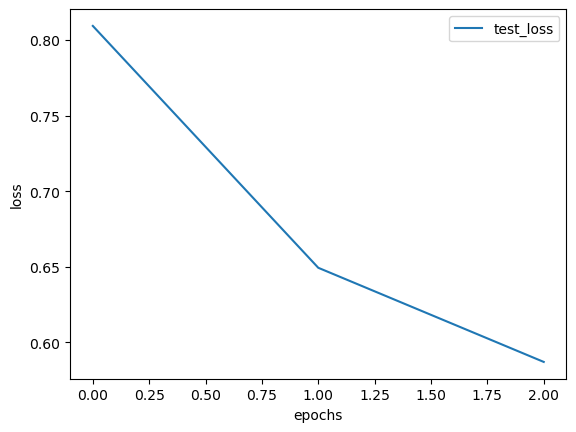

最高LOSS:0.5869489286816725


In [13]:
# lossのグラフ化
df_log = pd.DataFrame({"test_loss":test_loss,
             "test_accuracy":test_accuracy})
df_log[["test_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()
print(f'最高LOSS:{df_log["test_loss"].min()}')

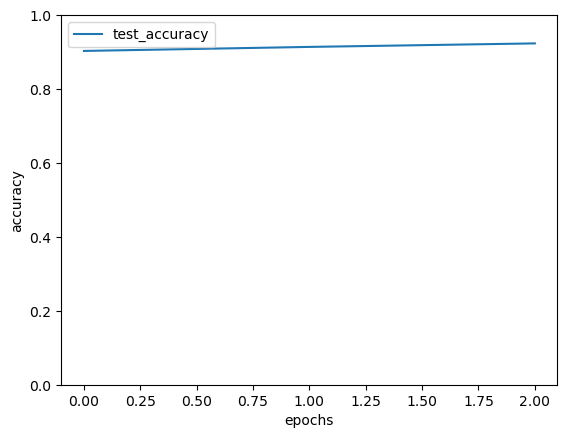

最高精度:0.9235


In [14]:
df_log[["test_accuracy"]].plot()
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.ylim(0, 1)
plt.show()
print(f'最高精度:{df_log["test_accuracy"].max()}')

## 学習済みモデルの出力

In [15]:
with open("model.pickle", "wb") as f:
    pickle.dump(tnet, f)

## 現状最良精度

In [16]:
df_log[df_log["test_accuracy"]==df_log["test_accuracy"].max()]

,test_loss,test_accuracy
2,0.586949,0.9235
